In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('../input/')
feature_dir = Path('../feature')
val_dir = Path('../txt')
tst_dir = Path('../txt')
sub_dir = Path('../submission/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'rfcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 26)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,g_r,u_g,r_i,i_z,u_r,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ug,d_dered_gr,d_dered_iz,d_dered_ur,d_dered_ri,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.3723,1.1898,0.0,1.3273,2.9272,1.3371,0.7328,4.2545,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,2.8665,1.3027,0.7232,4.1691,1.3230,2.1456
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.5266,1.2533,1.0,0.6096,0.9902,0.1840,0.0995,1.5997,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,0.9619,0.5931,0.1016,1.5550,0.1751,1.3163
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,0.7413,1.0225,0.0,0.2891,0.9610,0.1428,0.0435,1.2501,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,0.9211,0.2466,0.0257,1.1676,0.1183,1.4821
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,0.9591,1.2054,0.0,0.9676,4.4719,0.3262,0.2603,5.4395,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,4.3590,0.9074,0.2395,5.2664,0.2926,1.4454
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.2917,1.1939,0.0,1.6568,3.7543,0.7182,0.3415,5.4111,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,3.3376,1.5709,0.3144,4.9084,0.6727,1.9857


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 25) (80000, 25)


In [8]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:

p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.6,
                                 random_state=seed,
                                 n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [10]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.2087%


In [11]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [12]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

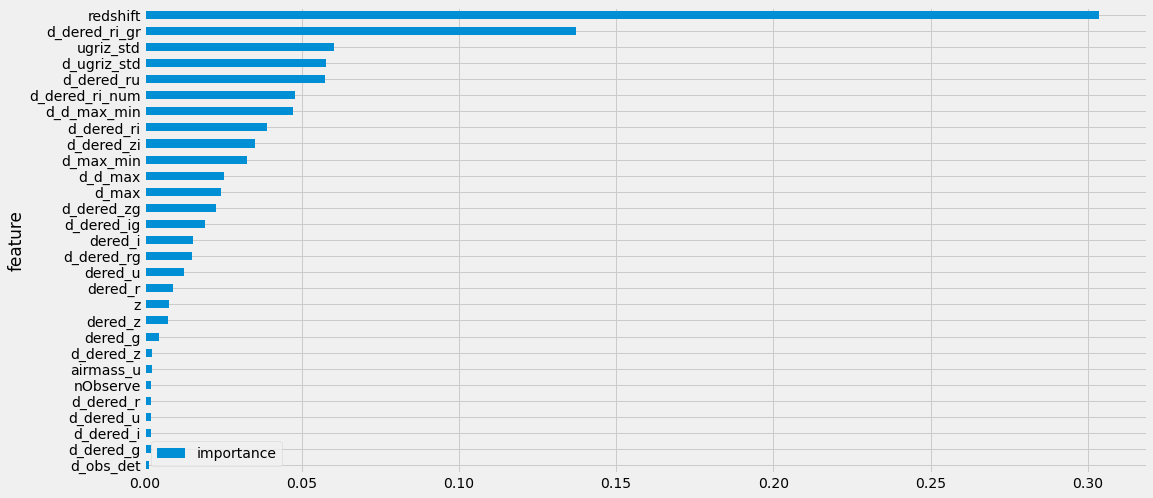

In [13]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [14]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [15]:

sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [16]:
sub[target_col].value_counts()

2    41106
0    29961
1     8933
Name: class, dtype: int64

In [17]:
sub.to_csv(sub_file)